# EP #1 - Camera Calibration

Computer Vision - DCC/ICEx/UFMG \
Prof. Ericksson Nascimento

Renato Sérgio Lopes Júnior

In [1]:
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

# Calibration with Direct Parameter Estimation

Based on Chapter 6 of [1]. We directly estimate the extrinsic parameters ($R$ and $T$) and the intrinsic ones ($f_x$ and $\alpha$), given a $N$ amount of correspondences between world coordinates and image coordinates.

## Defining image and world coordinates

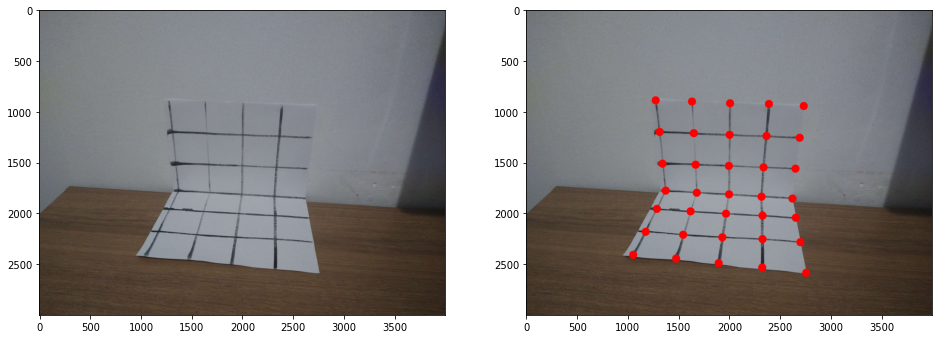

In [2]:
N = 35
world_coords = [[0, 0, 0], [50, 0, 0], [100, 0, 0], [150, 0, 0], [200, 0, 0], [0, 0, 50], [50, 0, 50], [100, 0, 50], [150, 0, 50], [200, 0, 50], [0, 0, 100], [50, 0, 100], [100, 0, 100], [150, 0, 100], [200, 0, 100], [0, 0, 150], [50, 0, 150], [100, 0, 150], [150, 0, 150], [200, 0, 150], [0, 50, 0], [50, 50, 0], [100, 50, 0], [150, 50, 0], [200, 50, 0], [0, 100, 0], [50, 100, 0], [100, 100, 0], [150, 100, 0], [200, 100, 0], [0, 150, 0], [50, 150, 0], [100, 150, 0], [150, 150, 0], [200, 150, 0]]
image_coords = [[1376,1776], [1682,1797], [2000, 1813], [2320, 1836], [2625, 1854], [1289, 1956], [1621, 1980], [1970, 2003], [2330, 2022], [2658, 2043], [1179, 2181], [1548, 2210], [1934, 2235], [2330, 2253], [2703, 2283], [1056, 2408], [1479, 2444], [1898, 2489], [2327, 2532], [2760, 2585], [1344, 1511], [1671, 1521], [1998, 1533], [2340, 1547], [2655, 1560], [1317, 1199], [1653, 1211], [2006, 1227], [2369, 1239], [2696, 1256], [1277, 888], [1635, 900], [2010, 917], [2393, 924], [2736, 944]]

image = cv2.imread("imgs/1.jpg")

image_plotted = image.copy()
for point in image_coords:
    image_plotted = cv2.circle(image_plotted, tuple(point), 40, (0,0,255), -1)

fig = plt.figure(figsize=(16, 32))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_plotted, cv2.COLOR_BGR2RGB))
plt.show()

## Creating matrix A and computing the SVD

In [3]:
def compute_SVD(A):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    return U, S, Vt

In [4]:
def create_matrix_A(image_coords, world_coords, N):
    A = np.zeros([N, 8])
    for i in range(N):
        x = image_coords[i][0]
        y = image_coords[i][1]
        X = world_coords[i][0]
        Y = world_coords[i][1]
        Z = world_coords[i][2]
        A[i][0] = x*X
        A[i][1] = x*Y
        A[i][2] = x*Z
        A[i][3] = x
        A[i][4] = -y*X
        A[i][5] = -y*Y
        A[i][6] = -y*Z
        A[i][7] = -y
    return A

# Create matrix A
A = create_matrix_A(image_coords, world_coords, N)
# Compute SVD of A
U, S, Vt = compute_SVD(A)
# Get V
index = np.argmin(S) # Get index of lowest element
V = Vt[index]

## Computing $R$, $T$, $\alpha$ and $f_x$

In [5]:
# Compute gamma and alpha
gamma = np.sqrt((V[0]**2) + (V[1]**2) + (V[2]**2))
alpha = np.sqrt((V[4]**2) + (V[5]**2) + (V[6]**2))/gamma

In [6]:
# Recover the first two rows of R
R = np.zeros([3, 3])
R[1][0] = V[0]/gamma
R[1][1] = V[1]/gamma
R[1][2] = V[2]/gamma
R[0][0] = V[4]/(gamma*alpha)
R[0][1] = V[5]/(gamma*alpha)
R[0][2] = V[6]/(gamma*alpha)

# Compute the third row of R
R[2] = np.cross(R[0], R[1])

# Enforce orthogonality in R
U, S, Vt = compute_SVD(R)
R = np.matmul(U, Vt)

In [7]:
# Recover the first two components of T
T = np.zeros([3])
T[1] = V[3]/gamma
T[0] = V[7]/(gamma*alpha)

In [8]:
# Check if sign must change
P = 0 # Selected point
if image_coords[P][0]*(R[0][0]*world_coords[P][0] + R[0][1]*world_coords[P][1] + R[0][2]*world_coords[P][2] + T[0]) > 0:
    R[0] = (-1) * R[0]
    R[1] = (-1) * R[1]
    T[0] = (-1) * T[0]
    T[1] = (-1) * T[1]

In [9]:
# Estimate Tz and fx
def create_system(image_coords, world_coords, N, R, T):
    A = np.zeros([N, 2])
    b = np.zeros([N])
    for i in range(N):
        A[i][0] = image_coords[i][0]
        A[i][1] = R[0][0]*world_coords[i][0] + R[0][1]*world_coords[i][1] + R[0][2]*world_coords[i][2] + T[0]
        b[i] = -image_coords[i][0]*(R[2][0]*world_coords[i][0] + R[2][1]*world_coords[i][1] + R[2][2]*world_coords[i][2])
    return A, b    

A2, b = create_system(image_coords, world_coords, N, R, T)
S = np.linalg.lstsq(A2, b, rcond=None)[0]
# S = np.matmul(np.matmul(np.linalg.inv(np.matmul(A2.transpose(), A2)), A2.transpose()), b)
T[2] = S[0]
fx = S[1]

In [10]:
print('R', R)
print('T', T)
print('alpha', alpha)
print('fx', fx)

R [[-0.85263592  0.11735987  0.50915484]
 [ 0.04845703  0.98800991 -0.14658903]
 [-0.5202537  -0.10031494 -0.84809964]]
T [-188.29565048 -264.22199502  665.6317104 ]
alpha 1.0777501849175255
fx 4467.032140342428


# Naïve Calibration

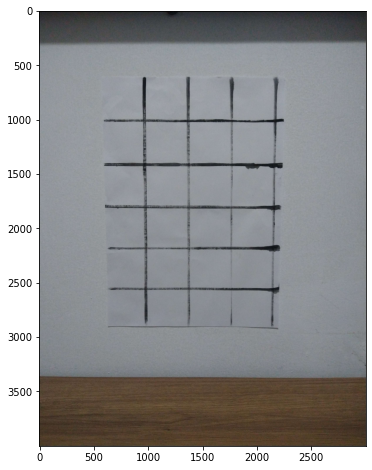

In [11]:
dX, dY = 210, 297 # Size of object in mm
dZ = 400 # Distance between object and camera in mm

dx, dy = 1570, 2300 # Size of object in pixels

image_naive = cv2.imread("imgs/naive_1.jpg")

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_naive, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
naive_fx = (float(dx)/dX)*dZ
naive_fy = (float(dy)/dY)*dZ

print('naive_fx', naive_fx)
print('naive_fy', naive_fy)

naive_fx 2990.4761904761904
naive_fy 3097.6430976430975


# Octave Calibration Toolbox

```
Calibration results after optimization (with uncertainties):

Focal Length:          fc = [ 3405.98696   3323.50591 ] +/- [ 567.53469   440.03055 ]
Principal point:       cc = [ 1648.52225   2055.41343 ] +/- [ 496.97716   754.64511 ]
Skew:             alpha_c = [ 0.00000 ] +/- [ 0.00000  ]   => angle of pixel axes = 90.00000 +/- 0.00000 degrees
Distortion:            kc = [ -0.18978   0.33212   0.02724   -0.01952  0.00000 ] +/- [ 0.28029   0.51425   0.05557   0.03066  0.00000 ]
Pixel error:          err = [ 8.45720   8.64052 ]

Note: The numerical errors are approximately three times the standard deviations (for reference).
```

The calibration was made using images 1.jpg, 2.jpg, 3.jpg, 4.jpg and 5.jpg.

# Discussion

When we compare the results of each approach (Direct Parameter Calibration, Naïve Calibration and the Toolbox Calibration), we can see that the results for the intrinsic parameter $f_x$ is approximately in the range from 3000 to 4000. There is a significant discrepancy between the results obtained by each method, as was expected, given that each one is based on a set of assumptions about the scene and the image. In particular, the difference between the Direct approach result and the Toolbox one may be explained by the different amount of images used: while the first uses correspondences from a single image, the latter uses correspondences from 5 different images.

# References

[1] Trucco, Emanuele & Verri, Alessandro. (1998). Introductory techniques for 3-D computer vision.